In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses

from tensorflow.keras.metrics import AUC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/waterQuality/all4classes.csv')

In [5]:
# calculate word count of each sentence
train_data['word_counter'] = train_data['body'].apply(lambda x:len(str(x).split())) 

In [7]:
print('Info about training data:')
print(train_data['cod'].value_counts())
print('Total comments: ', len(train_data))

# will be used in cnn
max_train_sentence_length  = train_data['word_counter'].max()

Info about training data:
2    5572
0    5032
1    4825
3    4395
Name: cod, dtype: int64
Total comments:  19824


In [9]:
# consider 30k comments
num_words = 30000

# convert texts to number format - for tensorflow.

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['body'].values.astype(str).tolist())

print(str(tokenizer.texts_to_sequences(['this is a test'])))

[[11, 1, 1, 667]]


In [10]:
# splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(train_data['body'],\
                                                      train_data['cod'],\
                                                      test_size=0.2,\
                                                      random_state=0)

In [11]:
# text-to-number
x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )

<ipython-input-11-52717cdf9361>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
<ipython-input-11-52717cdf9361>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )


In [12]:
x_train = pad_sequences(x_train, padding='post', maxlen=256)
x_test = pad_sequences(x_test, padding='post', maxlen=256)

In [13]:
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_test)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

[0, 1, 2, 3]

In [14]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

In [15]:
# Details for label encoding process
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

15359    2
7610     1
7352     1
13426    2
9179     1
15439    3
12826    2
3630     0
2632     0
7851     1
Name: cod, dtype: int64
Text to number
[2 1 1 2 1 3 2 0 0 1]
Number to category
[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [18]:
# Creating CNN Model

# looking for top 30k comments
max_features = 250000

#every index is represented by 64 dimensional vector
embedding_dim =64

#each input has 256 dimension
sequence_length = 256

model = tf.keras.Sequential()

# first layer is embedding layer.
model.add(tf.keras.layers.Embedding(max_features, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))     

# second is conv. layer.
# 1-dimensional for texts (2D for images)
# kernel_size = 3, looking for 3 words at a time (total of 256).
model.add(tf.keras.layers.Conv1D(128, 3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005))) 

# adding maxpooling after convolution layer.
# feature map is reduced by half after max pooling.
model.add(tf.keras.layers.GlobalMaxPooling1D())

# final layer, fully connected dense layer.
# 3 neurons for the output: possitive, negative and neutral.
# regularizers prevent overfitting.
model.add(tf.keras.layers.Dense(4, activation='softmax',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
                    
model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy",  AUC(name='auc')])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 64)           16000000  
                                                                 
 conv1d_1 (Conv1D)           (None, 254, 128)          24704     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 16,025,220
Trainable params: 16,025,220
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Training model
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs=10,
                    validation_data=test_ds.batch(128),
                    verbose=1)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


124/124 [==============================] - 29s 226ms/step - loss: 1.9209 - categorical_accuracy: 0.6529 - auc: 0.8832 - val_loss: 0.5361 - val_categorical_accuracy: 0.8383 - val_auc: 0.9698
Epoch 2/10
124/124 [==============================] - 27s 216ms/step - loss: 0.4787 - categorical_accuracy: 0.8514 - auc: 0.9765 - val_loss: 0.4626 - val_categorical_accuracy: 0.8522 - val_auc: 0.9775
Epoch 3/10
124/124 [==============================] - 26s 208ms/step - loss: 0.4196 - categorical_accuracy: 0.8779 - auc: 0.9835 - val_loss: 0.4639 - val_categorical_accuracy: 0.8532 - val_auc: 0.9778
Epoch 4/10
124/124 [==============================] - 26s 208ms/step - loss: 0.3908 - categorical_accuracy: 0.9028 - auc: 0.9872 - val_loss: 0.4754 - val_categorical_accuracy: 0.8562 - val_auc: 0.9776
Epoch 5/10
124/124 [==============================] - 27s 217ms/step - loss: 0.3723 - categorical_accuracy: 0.9163 - auc: 0.9898 - val_loss: 0.4833 - val_categorical_accuracy: 0.8547 - val_auc: 0.9779
Epoch 

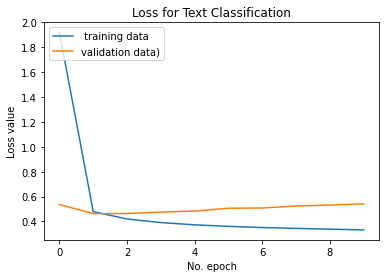

In [20]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

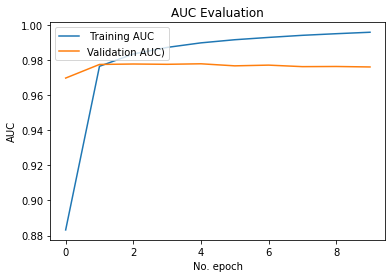

In [21]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC)')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [22]:
X_test

11838    struggling hard the lastyear lol looking for s...
8942     after sum drinkswhether its the same day night...
3494            use bread machine literally add water lmao
3261     those moments are the reason love this sport w...
8434     fun after effects having cvd year later coughi...
                               ...                        
7803     album going called shallow water shall will ha...
19595    proof pic one glass water and one floating nee...
16312    thank you cosmosmagazine thanks research aibn ...
9366     digestive system entirely doesnt work anymore ...
13671    see most are not not sensitive little princess...
Name: body, Length: 3965, dtype: object

In [27]:
x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )
x_test2 = pad_sequences(x_test2, padding='post', maxlen=512)

<ipython-input-27-95411db72295>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )


In [28]:
print("Generate predictions for all samples")
y_predictions = model.predict(x_test2)
y_pred = y_predictions.argmax(axis=1)
y_pred

Generate predictions for all samples
124/124 [==============================] - 2s 13ms/step


array([2, 1, 0, ..., 3, 1, 2])

In [29]:
y_test.shape
y_test

11838    2
8942     1
3494     0
3261     0
8434     1
        ..
7803     1
19595    3
16312    3
9366     1
13671    2
Name: cod, Length: 3965, dtype: int64

In [30]:
labels = [0, 1, 2, 3]
#labels = labels.values.astype(int).astype(str)
print(classification_report(y_test, y_pred, labels=labels))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       972
           1       0.95      0.89      0.92       996
           2       0.89      0.77      0.82      1091
           3       0.78      0.89      0.83       906

    accuracy                           0.85      3965
   macro avg       0.85      0.85      0.85      3965
weighted avg       0.85      0.85      0.85      3965

